##### Problem statement: - To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
#!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.layers import Flatten, Dense, Dropout

### Step 1: Importing Data

Dataset Having 2357 images (2239 on Train Dataset and 118 of Test Dataset)of skin cancer types. Dataset contains 9 sub-directories in each train and test subdirectories. All 9 sub-directories contains images of 9 skin cancer types Images respectively.

In [11]:
# Defining path for train and test images
data_dir_path = "C:/Users/shipr/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(data_dir_path + '/Train')
data_dir_test = pathlib.Path(data_dir_path + '/Test')

In [12]:

# Counting number of images in Train and Test directory Using the glob to retrieve files/pathnames matching a specified pattern.

# displaying Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Image count in Train Dataset: ", image_count_train)

# Displaying Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Image count in Test Dataset: ",image_count_test)

Image count in Train Dataset:  2239
Image count in Test Dataset:  118


#### Dataset uses about 2239 images of Skin Cancer Type for Train Dataset and 118 Images for Test Dataset

In [13]:
# consider Batch Size 32 and height and width as 180.
batch_size = 32
img_height = 180
img_width = 180

In [14]:
# defining Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=.2,
    subset="training",
)
#  **kwargs  showing error

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### load images using keras.utils and Using 80 % of the images for Trainning and rest 20 % images for Validation

In [15]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=.2,
    subset="validation",  
)
#  **kwargs  showing error

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# Listing out all the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualizing the data

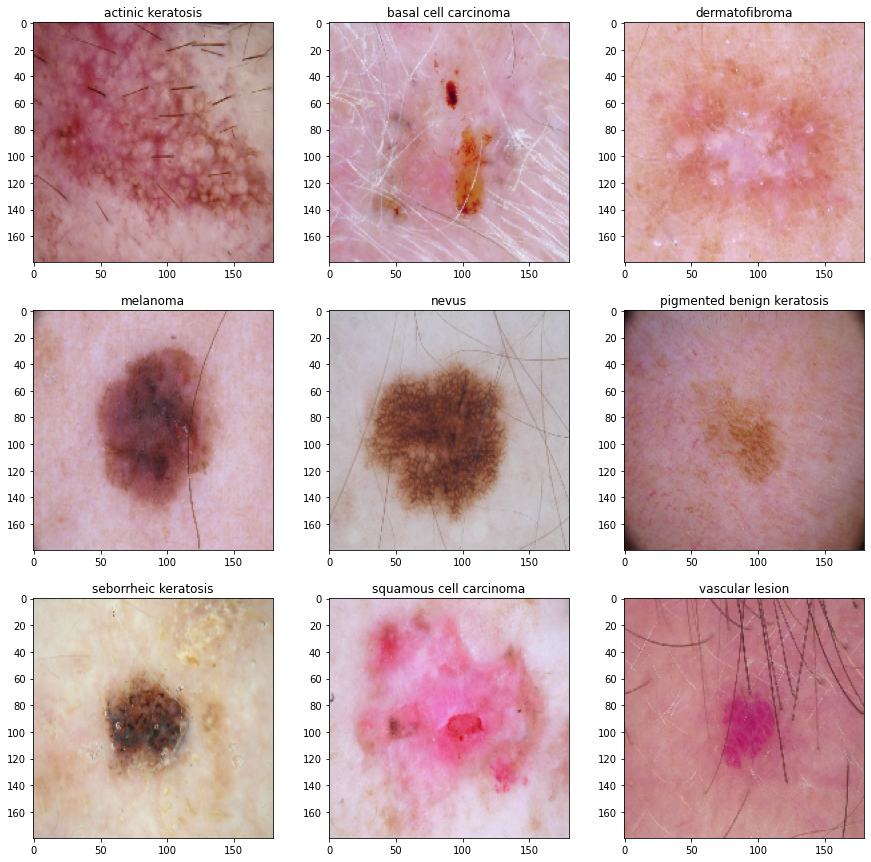

In [17]:
# importing library
from tensorflow.keras.preprocessing.image import load_img

# Dictionary to store the path of image as per the their class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
# Visualize image 

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The image_batch is a tensor of shape (32,180,180,3) its a batch of 32

images of shape (180 * 180 * 3 ) # here last dimension 3 indicating color channel RGB. Label batch is Tensor of shape 32.

    -Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

    -Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [19]:
input_shape = (img_height, img_width, 3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),

# First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

# Second Convulation Layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

# Third Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
  layers.Flatten(),
   
# Dense Layer    
  layers.Dense(128, activation='relu'),
    
    
# model..dense
  layers.Dense(num_classes)
])
    

In [20]:

# using appropirate optimiser and loss function for compile the model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])  # from_logits=True removed due to error

In [21]:
# Showing the summary of all the layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 42s 566ms/step - loss: 1.9514 - accuracy: 0.2852 - val_loss: 1.6205 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 28s 502ms/step - loss: 1.6011 - accuracy: 0.4319 - val_loss: 1.5585 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 28s 500ms/step - loss: 1.4800 - accuracy: 0.4810 - val_loss: 1.5000 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 30s 544ms/step - loss: 1.3569 - accuracy: 0.5290 - val_loss: 1.4592 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 31s 560ms/step - loss: 1.2869 - accuracy: 0.5469 - val_loss: 1.4258 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 32s 579ms/step - loss: 1.1582 - accuracy: 0.5938 - val_loss: 1.5361 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 33s 592ms/step - loss: 1.1013 - accuracy: 0.6049 - val_loss: 1.5663 - val_accuracy: 0.5257

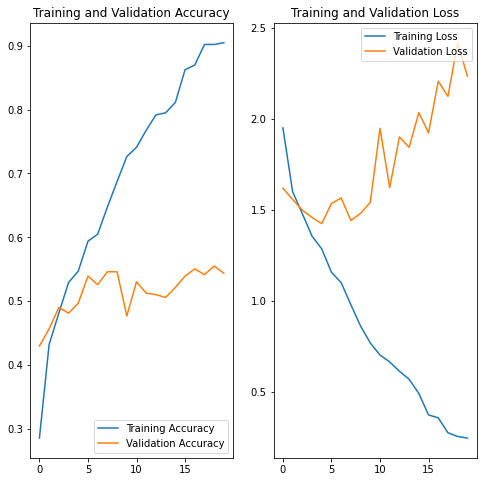

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Infrence after the first model fit
    -we can't say its a good model its not generalized model.
    -Training dataset having some noise in data, showing good result for Training dataset as compared to validation dataset.
    -Training datset showing accuracy around 88% and validation dataset showing around53 %accuracy.
    -from above conculusion we can conclude that model is overfitting
    - From above Graph Training and Validation accuracy graph we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases, also the difference in Training and Validation Loss function increases.


In [25]:
# Data augumentation strategy. 
# To rescale an input in the [0, 255] range to be in the [0, 1] range
# rescale = tf.keras.Sequential([ layers.experimental.preprocessing.Rescaling(1./255)])
# random flip -  randomly flip every image horizontally and vertically.
  
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                input_shape = (img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.3)
])

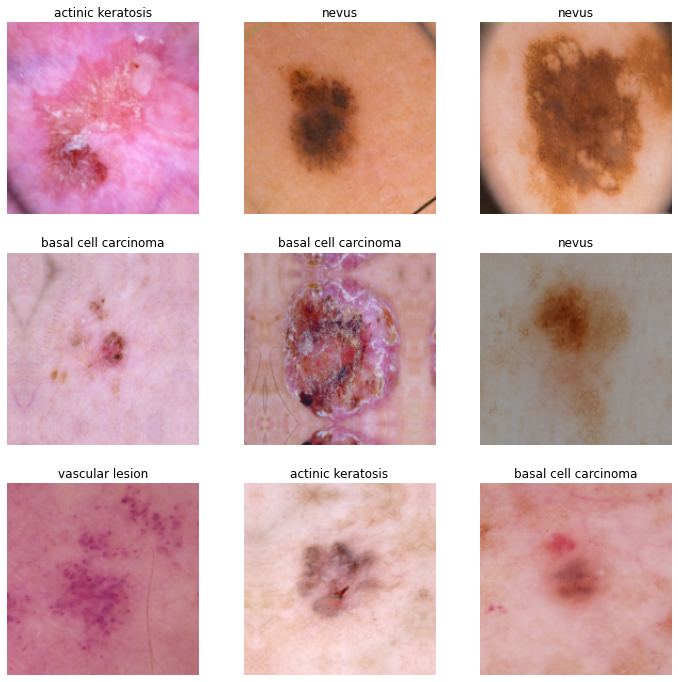

In [26]:
# Visualizing the augmentation images

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Model : 2 Creation

In [27]:
input_shape = (img_height, img_width, 3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),

# First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),

# Second Convulation Layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
# Third Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
  layers.Flatten(),
# Dropout Layer
  layers.Dropout(.25),
# Dense Layer    
  layers.Dense(128, activation='relu'),
  
    
# model.add(Dense(num_classes, activation='softmax'))
  layers.Dense(num_classes)
])

In [28]:
# using appropirate optimiser and loss function for compile the model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])  # from_logits=True removed due to error

In [29]:
# Showing the summary of all the layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [30]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 37s 626ms/step - loss: 2.3635 - accuracy: 0.1830 - val_loss: 2.0553 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 35s 619ms/step - loss: 2.0017 - accuracy: 0.2427 - val_loss: 1.9421 - val_accuracy: 0.2774
Epoch 3/20
56/56 [==============================] - 35s 627ms/step - loss: 1.8481 - accuracy: 0.3404 - val_loss: 1.7964 - val_accuracy: 0.3087
Epoch 4/20
56/56 [==============================] - 35s 628ms/step - loss: 1.6528 - accuracy: 0.4046 - val_loss: 1.6096 - val_accuracy: 0.4452
Epoch 5/20
56/56 [==============================] - 35s 628ms/step - loss: 1.5310 - accuracy: 0.4615 - val_loss: 1.5251 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 38s 672ms/step - loss: 1.5129 - accuracy: 0.4520 - val_loss: 1.5479 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 38s 682ms/step - loss: 1.4568 - accuracy: 0.4844 - val_loss: 1.4694 - val_accuracy: 0.5034

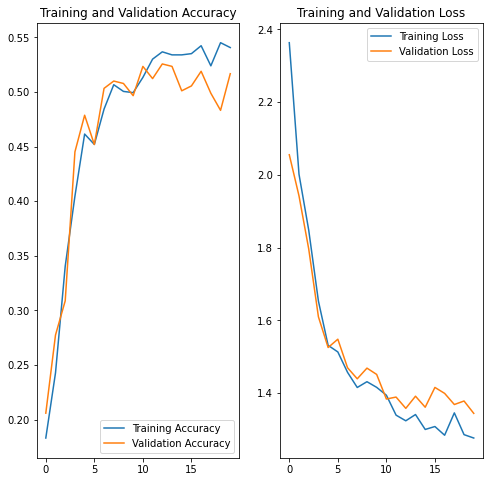

In [31]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### findings:

    1. From above graph we can clearly observe that the training accuracy and validation accuracy is close to each others. 
    which indicates data augumentation and dropout layer helped to reduce overfitting issue.
    2. but Model Performance is still not increased. trainig accuracy around 56 % and validation accuracy around 52 %.
    Training and validation are closed to each others Means model is Underfitting. we need to overcome from this issue.

In [32]:
def class_img_count(directory):
    
    # counting number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    # listing name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    # return dataframe with images counting and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class Name', 'No. of Image Count'])

img_count = class_img_count(data_dir_train)
img_count

,Class Name,No. of Image Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


#### Graphical representation of number of images in each class

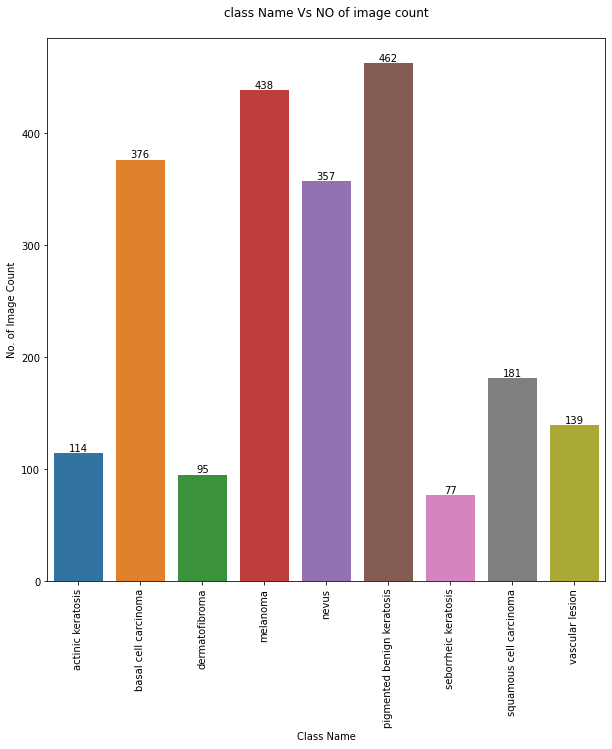

In [33]:
# Import Seborn library for visualisation
import seaborn as sns

plt.figure(figsize=(10, 10))
ax = sns.barplot(x='Class Name', y='No. of Image Count', data=img_count, errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('class Name Vs NO of image count\n')
plt.xticks(rotation=90)
plt.show()

#### Which class has the least number of samples?
findings:- From above results seborrheic keratosis has the least number of samples only 77 (about 3.4 %)

#### Which classes dominate the data in terms proportionate number of samples?
findings:- Top most dominating classes in datset are
    -pigmented benign keratosis 462 Samples (about 20.6 %)
    -melanoma 438 Samples (about 19.5 %)
    -basal cell carcinoma 376 Samples (about 16.7 %)
    -nevus 357 Samples (about 15.9 %)

In [35]:
# installing Augmentor using pip command
!pip install Augmentor

#### Augmentor Library layer code

In [36]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E500FD1670>: 100%|██████████| 500/500 [00:04<00:00, 110.12 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E50690F220>: 100%|██████████| 500/500 [00:04<00:00, 108.50 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E50C811100>: 100%|██████████| 500/500 [00:05<00:00, 97.99 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x545 at 0x1E50C832E20>: 100%|██████████| 500/500 [00:21<00:00, 22.87 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1E50689F5B0>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E506A21E80>: 100%|██████████| 500/500 [00:04<00:00, 108.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E50C81CA60>: 100%|██████████| 500/500 [00:11<00:00, 44.42 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E50C8292B0>: 100%|██████████| 500/500 [00:04<00:00, 106.85 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\shipr\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E50694CC70>: 100%|██████████| 500/500 [00:04<00:00, 102.94 Samples/s]


In [37]:
# Counting number of images generated by Augmentor.

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [38]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\shipr\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3d849251-f4cd-4ee0-92ec-18c27ad31146.jpg',
 'C:\\Users\\shipr\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_42498d01-29c9-4a14-95e4-c1b42d05a610.jpg',
 'C:\\Users\\shipr\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_519ea5a1-f993-4be8-a96b-6be1ede341b6.jpg',
 'C:\\Users\\shipr\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_83dbf234-7435-4a81-bb08-c7be793130a1.jpg',
 'C:\\Users\\shipr\\Downloads\\CNN_assignment\\Skin cancer ISIC The Internat

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:

# dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [42]:

# label count.
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

### Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating Training dataset

In [44]:
# Training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,                    # to overcome from randomness
  validation_split = 0.2,      # 20 % of data reserve for validation 
  subset = 'training',          # subset for training set
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [45]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,                    # to overcome from randomness
  validation_split = 0.2,      # 20 % of data reserve for validation 
  subset = 'validation',          # subset for training set
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model 3

In [46]:
input_shape = (img_height, img_width, 3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model3 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),

# First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),

# Second Convulation Layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),
# Third Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
  layers.Flatten(),
# Dropout Layer
  layers.Dropout(.25),
# Dense Layer    
  layers.Dense(128, activation='relu'),
  
    
# model.add(Dense(num_classes, activation='softmax'))
  layers.Dense(num_classes)
])

In [47]:
# using appropirate optimiser and loss function for compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model3.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])  # from_logits=True removed due to error

In [48]:
# Showing the summary of all the layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [49]:
epochs = 30
history = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/30
169/169 [==============================] - 134s 780ms/step - loss: 2.3164 - accuracy: 0.1365 - val_loss: 2.1841 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 134s 789ms/step - loss: 2.0804 - accuracy: 0.2027 - val_loss: 1.8437 - val_accuracy: 0.3296
Epoch 3/30
169/169 [==============================] - 138s 815ms/step - loss: 1.7366 - accuracy: 0.3353 - val_loss: 1.6900 - val_accuracy: 0.3608
Epoch 4/30
169/169 [==============================] - 136s 801ms/step - loss: 1.5783 - accuracy: 0.3952 - val_loss: 1.5110 - val_accuracy: 0.4172
Epoch 5/30
169/169 [==============================] - 143s 842ms/step - loss: 1.5355 - accuracy: 0.4117 - val_loss: 1.4909 - val_accuracy: 0.4180
Epoch 6/30
169/169 [==============================] - 147s 863ms/step - loss: 1.4640 - accuracy: 0.4329 - val_loss: 1.5132 - val_accuracy: 0.4068
Epoch 7/30
169/169 [==============================] - 137s 806ms/step - loss: 1.4254 - accuracy: 0.4429 - val_loss: 1.4152 -

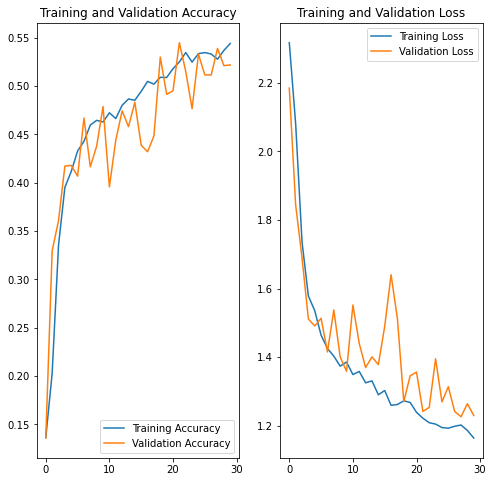

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### findings
    -if we analyse accuracy of model 3 is less but difference in validation and trainning is also less which is good for    model 3
    - Trying to remove augmentation layer from model and checking performance

In [51]:
input_shape = (img_height, img_width, 3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model4 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),

# First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),

# Second Convulation Layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),
# Third Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 
# Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
  layers.Flatten(),
# Dropout Layer
  layers.Dropout(.25),
# Dense Layer    
  layers.Dense(128, activation='relu'),
  
    
# model.add(Dense(num_classes, activation='softmax'))
  layers.Dense(num_classes)
])

In [52]:
# using appropirate optimiser and loss function for compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model4.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])  # from_logits=True removed due to error

In [53]:
# Showing the summary of all the layers
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [54]:
epochs = 30
history = model4.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/30
169/169 [==============================] - 112s 657ms/step - loss: 2.1487 - accuracy: 0.2068 - val_loss: 1.8888 - val_accuracy: 0.2725
Epoch 2/30
169/169 [==============================] - 113s 667ms/step - loss: 1.6497 - accuracy: 0.3594 - val_loss: 1.5892 - val_accuracy: 0.4031
Epoch 3/30
169/169 [==============================] - 113s 666ms/step - loss: 1.4674 - accuracy: 0.4373 - val_loss: 1.4616 - val_accuracy: 0.4284
Epoch 4/30
169/169 [==============================] - 112s 660ms/step - loss: 1.3581 - accuracy: 0.4913 - val_loss: 1.5226 - val_accuracy: 0.4246
Epoch 5/30
169/169 [==============================] - 112s 661ms/step - loss: 1.2246 - accuracy: 0.5527 - val_loss: 1.3517 - val_accuracy: 0.4818
Epoch 6/30
169/169 [==============================] - 112s 659ms/step - loss: 1.1036 - accuracy: 0.5933 - val_loss: 1.1092 - val_accuracy: 0.5932
Epoch 7/30
169/169 [==============================] - 113s 663ms/step - loss: 1.0110 - accuracy: 0.6226 - val_loss: 1.1959 -

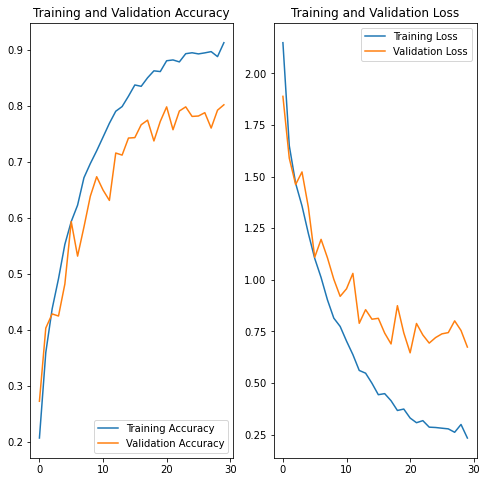

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of results
    -After adding 500 images of each category, we can clearly see the results have been improved in both training and validation dataset.
    -Also, overfitting and underfitting issue have been resolved in the final model.
    -Adding the images helped in resolving the class imbalance issue for both training and validation dataset.
    -We can also observe that the results are satisfactory now. Accuracy came around 88% for training and 79 % for         validation.